# Field Validation

In [10]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *
from utils.Plots import *


In [2]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_gereinigt.csv')
#df = df.drop(columns=['Unnamed: 0']) 
df.head(5)

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360


In [3]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape



((2427, 100), (259, 100))

In [4]:
# Make predictions using autoencoder
autoencoder = tf.keras.models.load_model('../../models/autoencoder_best.keras')
with open('../../models/autoencoder_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\liuzi\AppData\Local\Temp\ipykernel_19188\2162391532.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


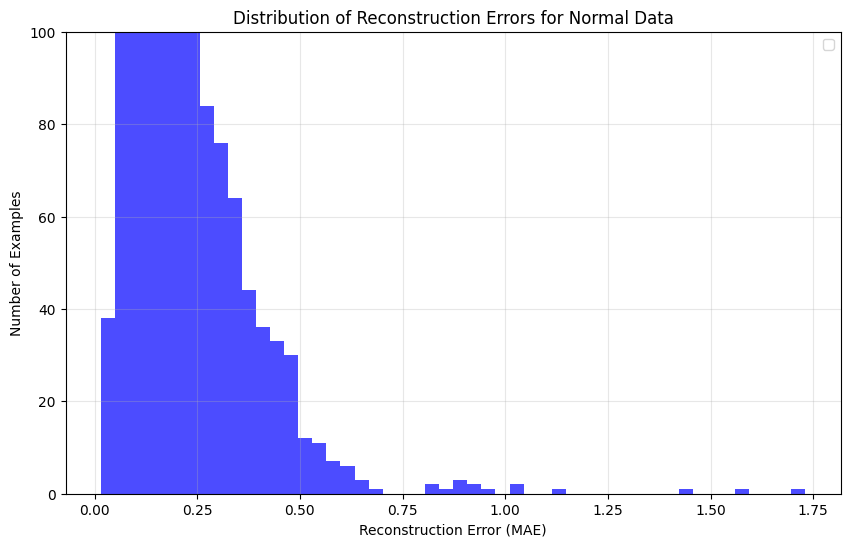

In [5]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = autoencoder.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal, bins=50, color='blue', alpha=0.7)

plt.title('Distribution of Reconstruction Errors for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


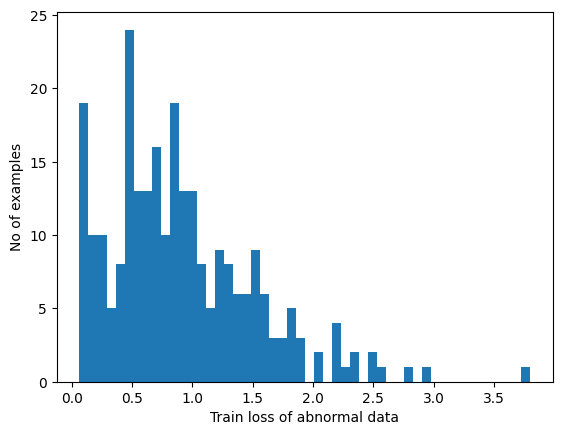

In [6]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = autoencoder.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.hist(train_loss_abnormal[None,:], bins=50)
plt.xlabel("Train loss of abnormal data")
plt.ylabel("No of examples")
plt.show()


--- Using Low Threshold: 0.390000 ---


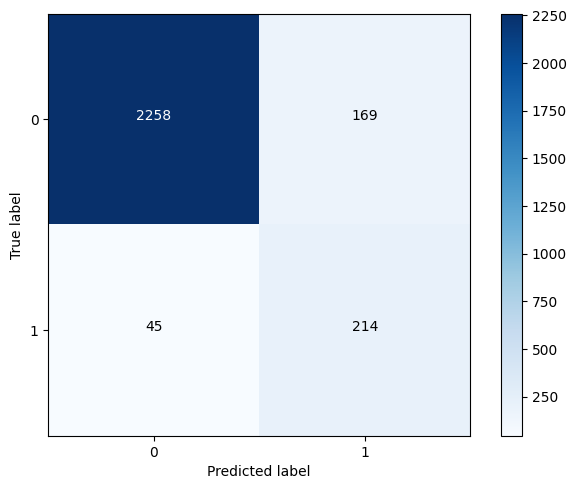


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2427
           1       0.56      0.83      0.67       259

    accuracy                           0.92      2686
   macro avg       0.77      0.88      0.81      2686
weighted avg       0.94      0.92      0.93      2686

Accuracy: 0.9203
Precision: 0.5587
Recall: 0.8263
F1 Score: 0.6667


In [18]:
def create_confusion_matrix(threshold, threshold_name):
    print(f"\n--- Using {threshold_name}: {threshold:.6f} ---")
    
    # Prepare the true labels and predictions
    true_labels = []
    predictions = []
    
    # Normal data (label 0)
    normal_predictions = (train_loss_normal.numpy() > threshold).astype(int)
    true_labels.extend([0] * len(normal_predictions))
    predictions.extend(normal_predictions)
    
    # Abnormal data (label 1)
    abnormal_predictions = (train_loss_abnormal.numpy() > threshold).astype(int)
    true_labels.extend([1] * len(abnormal_predictions))
    predictions.extend(abnormal_predictions)
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    # Plot the confusion matrix
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    classes = ['0', '1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Label the plot
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=classes))
    
    # Calculate metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }

# Evaluate all thresholds
results = {}

if 'low_threshold' in loaded_thresholds:
    results['low'] = create_confusion_matrix(loaded_thresholds['low_threshold'], 'Low Threshold')

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


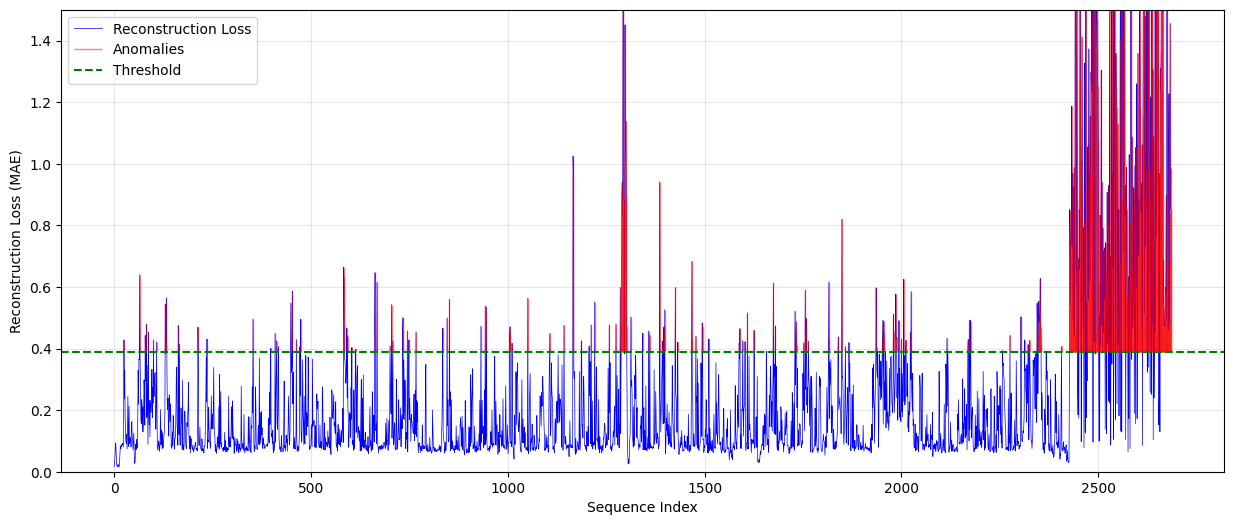

In [14]:
loss, anomaly_indices = plot_anomaly_reconstruction_loss(
    test_data_scaled_normal,
    test_data_scaled_abnormal,
    autoencoder,
    loaded_thresholds['low_threshold']
)